# Image classification with Swin Transformers

This example implements [Swin Transformer: Hierarchical Vision Transformer using Shifted Windows](https://arxiv.org/abs/2103.14030)
by Liu et al. for image classification, and demonstrates it on the
[CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Swin Transformer (**S**hifted **Win**dow Transformer) can serve as a general-purpose backbone
for computer vision. Swin Transformer is a hierarchical Transformer whose
representations are computed with _shifted windows_. The shifted window scheme
brings greater efficiency by limiting self-attention computation to
non-overlapping local windows while also allowing for cross-window connections.
This architecture has the flexibility to model information at various scales and has
a linear computational complexity with respect to image size.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Addons,
which can be installed using the following commands:

In [1]:
!pip install ipykernel -U tensorflow-addons matplotlib tensorflow numpy

  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)


## Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

2025-09-24 14:05:19.876549: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 14:05:19.880755: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-24 14:05:19.926294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-24 14:05:19.927209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 14:05:20.852368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Prepare the data

We load the CIFAR-100 dataset through `tf.keras.datasets`,
normalize the images, and convert the integer labels to one-hot encoded vectors.

In [3]:
# num_classes = 38
# input_shape = (32, 32, 3)

# (x_train, y_train), (x_test, y_test) = keras.datasets.cifar38.load_data()
# x_train, x_test = x_train / 255.0, x_test / 255.0
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)
# print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(x_train[i])
# plt.show()

Found 70295 files belonging to 38 classes.


2025-09-24 14:05:28.376746: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Found 17572 files belonging to 38 classes.
Found 33 files belonging to 38 classes.
Batch images shape: (32, 32, 32, 3)
Batch labels shape: (32, 38)


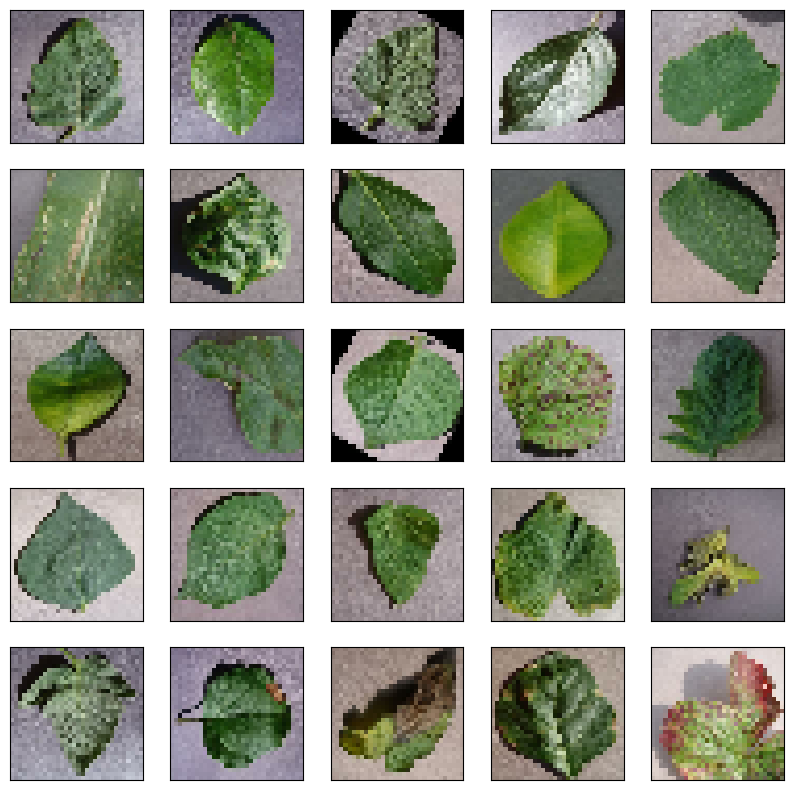

In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Cấu hình
num_classes = 38
input_shape = (32, 32, 3)   # resize ảnh về 32x32
img_size = input_shape[:2]
batch_size = 32

# Đường dẫn dataset trong Kaggle
dataset_dir = "dataset"

# Load training dataset
train_ds = keras.utils.image_dataset_from_directory(
    f"{dataset_dir}/train",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Load validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    f"{dataset_dir}/val",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Load test dataset
test_ds = keras.utils.image_dataset_from_directory(
    f"{dataset_dir}/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

# Chuẩn hóa [0,1]
normalization_layer = keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch để tăng tốc
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Kiểm tra batch
for images, labels in train_ds.take(1):
    print("Batch images shape:", images.shape)
    print("Batch labels shape:", labels.shape)

# Hiển thị 25 ảnh đầu tiên
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([]); plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].numpy())
    # plt.title(train_ds.class_names[labels[i].numpy().argmax()])
plt.show()

# print("Số lớp:", len(train_ds.class_names))
# print("Các lớp:", train_ds.class_names[:10], "...")


In [5]:
import numpy as np

# Chuyển tf.data thành numpy arrays
x_train = []
y_train = []
for images, labels in train_ds.unbatch():  # unbatch để lấy từng ảnh
    x_train.append(images.numpy())
    y_train.append(labels.numpy())
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = []
y_val = []
for images, labels in val_ds.unbatch():
    x_val.append(images.numpy())
    y_val.append(labels.numpy())
x_val = np.array(x_val)
y_val = np.array(y_val)

x_test = []
y_test = []
for images, labels in test_ds.unbatch():
    x_test.append(images.numpy())
    y_test.append(labels.numpy())
x_test = np.array(x_test)
y_test = np.array(y_test)

print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test.shape, "y_test:",  y_test.shape)


x_train: (70295, 32, 32, 3) y_train: (70295, 38)
x_val: (17572, 32, 32, 3) y_val: (17572, 38)
x_test: (33, 32, 32, 3) y_test: (33, 38)


## Configure the hyperparameters

A key parameter to pick is the `patch_size`, the size of the input patches.
In order to use each pixel as an individual input, you can set `patch_size` to `(1, 1)`.
Below, we take inspiration from the original paper settings
for training on ImageNet-1K, keeping most of the original settings for this example.

In [6]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 32  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 40
validation_split = 0.3
weight_decay = 0.0001
label_smoothing = 0.1

## Helper functions

We create two helper functions to help us get a sequence of
patches from the image, merge patches, and apply dropout.

In [7]:

def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


## Window based multi-head self-attention

Usually Transformers perform global self-attention, where the relationships between
a token and all other tokens are computed. The global computation leads to quadratic
complexity with respect to the number of tokens. Here, as the [original paper](https://arxiv.org/abs/2103.14030)
suggests, we compute self-attention within local windows, in a non-overlapping manner.
Global self-attention leads to quadratic computational complexity in the number of patches,
whereas window-based self-attention leads to linear complexity and is easily scalable.

In [8]:

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


## The complete Swin Transformer model

Finally, we put together the complete Swin Transformer by replacing the standard multi-head
attention (MHA) with shifted windows attention. As suggested in the
original paper, we create a model comprising of a shifted window-based MHA
layer, followed by a 2-layer MLP with GELU nonlinearity in between, applying
`LayerNormalization` before each MSA layer and each MLP, and a residual
connection after each of these layers.

Notice that we only create a simple MLP with 2 Dense and
2 Dropout layers. Often you will see models using ResNet-50 as the MLP which is
quite standard in the literature. However in this paper the authors use a
2-layer MLP with GELU nonlinearity in between.

In [9]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


## Model training and evaluation

### Extract and embed patches

We first create 3 layers to help us extract, embed and merge patches from the
images on top of which we will later use the Swin Transformer class we built.

In [10]:

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


### Build the model

We put together the Swin Transformer model.

In [11]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

### Train on CIFAR-100

We train the model on CIFAR-100. Here, we only train the model
for 40 epochs to keep the training time short in this example.
In practice, you should train for 150 epochs to reach convergence.

In [12]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        keras.metrics.TopKCategoricalAccuracy(1, name="top-1-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(x_val, y_val)
)



Epoch 1/40
2197/2197 [==============================] - 143s 63ms/step - loss: 1.9141 - accuracy: 0.5998 - top-5-accuracy: 0.8686 - top-1-accuracy: 0.5998 - val_loss: 1.4267 - val_accuracy: 0.7847 - val_top-5-accuracy: 0.9673 - val_top-1-accuracy: 0.7847
Epoch 2/40
2197/2197 [==============================] - 144s 65ms/step - loss: 1.3507 - accuracy: 0.8076 - top-5-accuracy: 0.9728 - top-1-accuracy: 0.8076 - val_loss: 1.2572 - val_accuracy: 0.8516 - val_top-5-accuracy: 0.9827 - val_top-1-accuracy: 0.8516
Epoch 3/40
2197/2197 [==============================] - 144s 65ms/step - loss: 1.2332 - accuracy: 0.8485 - top-5-accuracy: 0.9829 - top-1-accuracy: 0.8485 - val_loss: 1.1885 - val_accuracy: 0.8669 - val_top-5-accuracy: 0.9859 - val_top-1-accuracy: 0.8669
Epoch 4/40
2197/2197 [==============================] - 144s 65ms/step - loss: 1.1760 - accuracy: 0.8706 - top-5-accuracy: 0.9869 - top-1-accuracy: 0.8706 - val_loss: 1.1887 - val_accuracy: 0.8623 - val_top-5-accuracy: 0.9859 - val_top

Let's visualize the training progress of the model.

In [13]:
import torch
torch.save(model, "comparision/dataset1/with_swin/swintf.pth")

In [14]:
import os
os.makedirs("comparision/dataset1/with_swin", exist_ok=True)

# Tạo file txt để lưu log
log_file = "comparision/dataset1/with_swin/log.txt"

with open(log_file, "w") as f:
    for key, values in history.history.items():
        f.write(f"{key}: {values}\n")

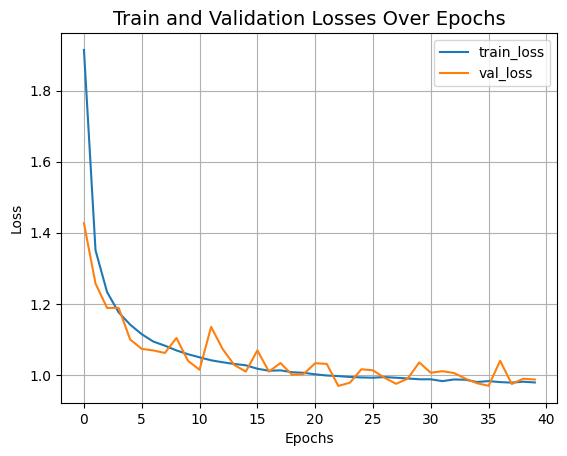

In [15]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

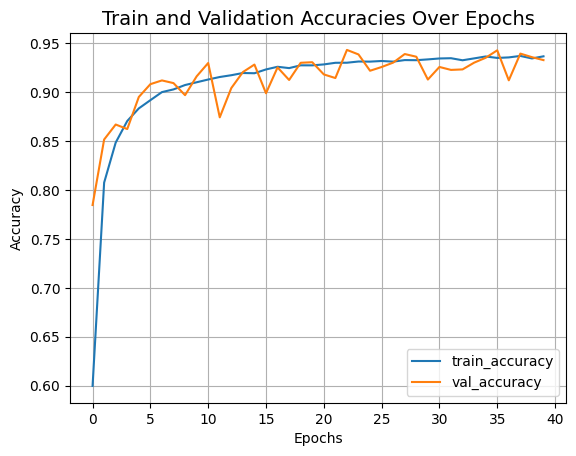

In [16]:
plt.plot(history.history["accuracy"], label="train_accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

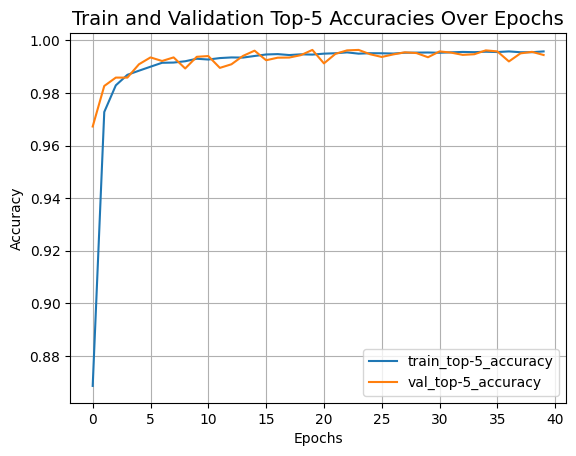

In [17]:
plt.plot(history.history["top-5-accuracy"], label="train_top-5_accuracy")
plt.plot(history.history["val_top-5-accuracy"], label="val_top-5_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Validation Top-5 Accuracies Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

Let's display the final results of the training on CIFAR-100.

In [18]:
model.evaluate(x_val, y_val)
# print(f"Test loss: {round(loss, 2)}")
# print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

550/550 [==============================] - 16s 28ms/step - loss: 0.9856 - accuracy: 0.9344 - top-5-accuracy: 0.9947 - top-1-accuracy: 0.9344


[0.9856029748916626, 0.9344411492347717, 0.994707465171814, 0.9344411492347717]

In [19]:
import os
from tensorflow.keras.preprocessing import image

folder_path = "dataset/test"
image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".JPG") or f.endswith(".JPEG")]
maps = ["Apple_Apple_scab", "Apple_Black_rot", "Apple_Cedar_apple_rust", "Apple_healthy",
        "Blueberry_healthy",
        "Cherry_(including_sour)_Powdery_mildew", "Cherry_(including_sour)_healthy",
        "Corn_(maize)_Cercospora_leaf_spot Gray_leaf_spot", "Corn_(maize)_Common_rust_",
        "Corn_(maize)_Northern_Leaf_Blight", "Corn_(maize)_healthy",
        "Grape_Black_rot", "Grape_Esca_(Black_Measles)", "Grape_Leaf_blight_(Isariopsis_Leaf_Spot)",
        "Grape_healthy",
        "Orange_Haunglongbing_(Citrus_greening)", "Peach_Bacterial_spot", "Peach_healthy",
        "Pepper,_bell_Bacterial_spot", "Pepper,_bell_healthy",
        "Potato_Early_blight", "Potato_Late_blight", "Potato_healthy",
        "Raspberry_healthy",
        "Soybean_Cyst_Nematode", "Soybean_Downy_mildew", "Soybean_Rust", "Soybean_healthy",
        "Squash_Cucumber_Mosaic_Virus", "Strawberry_Leaf_scorch", "Strawberry_healthy",
        "Tomato_Bacterial_spot", "Tomato_Early_blight", "Tomato_Late_blight", "Tomato_Leaf_Mold",
        "Tomato_Septoria_leaf_spot", "Tomato_Spider_mites Two-spotted_spider_mite",
        "Tomato_Target_Spot", "Tomato_YellowLeaf_Curl_Virus", "Tomato_mosaic_virus", "Tomato_healthy"]

# Preprocess and predict
for img_path in image_files:
    img = image.load_img(img_path, target_size=(32, 32))  # use your input size
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)  # batch dimension
    x = x / 255.0  # normalize if trained this way
    
    preds = model.predict(x)
    predicted_class = np.argmax(preds, axis=1)[0]
    
    print(f"{img_path} -> Class {predicted_class} ({maps[predicted_class]})")

The Swin Transformer model we just trained has just 152K parameters, and it gets
us to ~75% test top-5 accuracy within just 40 epochs without any signs of overfitting
as well as seen in above graph. This means we can train this network for longer
(perhaps with a bit more regularization) and obtain even better performance.
This performance can further be improved by additional techniques like cosine
decay learning rate schedule, other data augmentation techniques. While experimenting,
I tried training the model for 150 epochs with a slightly higher dropout and greater
embedding dimensions which pushes the performance to ~72% test accuracy on CIFAR-100
as you can see in the screenshot.

![Results of training for longer](https://i.imgur.com/9vnQesZ.png)

The authors present a top-1 accuracy of 87.3% on ImageNet. The authors also present
a number of experiments to study how input sizes, optimizers etc. affect the final
performance of this model. The authors further present using this model for object detection,
semantic segmentation and instance segmentation as well and report competitive results
for these. You are strongly advised to also check out the
[original paper](https://arxiv.org/abs/2103.14030).

This example takes inspiration from the official
[PyTorch](https://github.com/microsoft/Swin-Transformer) and
[TensorFlow](https://github.com/VcampSoldiers/Swin-Transformer-Tensorflow) implementations.